In [1]:
from collections import defaultdict
import json
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import plotly.graph_objects as go
import seaborn as sns

from scripts.eas_lists import OsoData
from scripts.oso_db import execute_query
from scripts.processing import (
    github_event_processor, 
    github_active_developers, 
    github_repos_analysis,
    github_network_graph
)

from visualizations.contribution_heatmap import contribution_heatmap
from visualizations.network_graph import network_graph
from visualizations.stacked_area import activity_plot
from visualizations.venn_diagram import venn3_diagram


DPI = 144 
plt.rcParams['figure.figsize'] = [10, 5]
plt.rcParams['figure.dpi'] = DPI
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.Set2.colors)
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False

OP_RED = "#FF0420"
OP_MED_RED = "#FF6969"
OP_LIGHT_RED = "#FFCCDD"

# Fetch / update data

In [2]:
DATA_DIR  = "data/RPGF3/"
DATA_PATH = DATA_DIR + "2023-11_06_RPGF3_cleaned_applicant_data.json"

RPGF2_DATE = '2023-04-01'
START_DATE = '2019-01-01'
END_DATE = '2023-10-01'

In [3]:
oso = OsoData(DATA_PATH)
individuals = list(oso.df[oso.df['Applicant Type'] == 'INDIVIDUAL']['Slug: Primary'].values)
slugs_to_names = dict(zip(oso.df['Slug: Primary'], oso.df['Project Name']))
slugs_to_names = {k: v[:30] for k,v in slugs_to_names.items()}
slugs = [s for s in oso.get_project_slugs() if s not in individuals]

Loaded 311 OSS projects from data/RPGF3/2023-11_06_RPGF3_cleaned_applicant_data.json.
Identified 311 unique slugs.


In [4]:
# create a mapping of projects to collections
query = """
    SELECT p."slug", c."slug" 
    FROM project p 
    JOIN collection_projects_project cpp ON p."id" = cpp."projectId"
    JOIN collection c ON cpp."collectionId" = c."id"
    """
result = execute_query(query, col_names=False)
cpp = {k: sorted([v for v, key in result if key == k]) for k in set(key for _, key in result)}

# Visualize dataset coverage

Total projects: 366


(<Figure size 1440x1440 with 1 Axes>, <AxesSubplot:>)

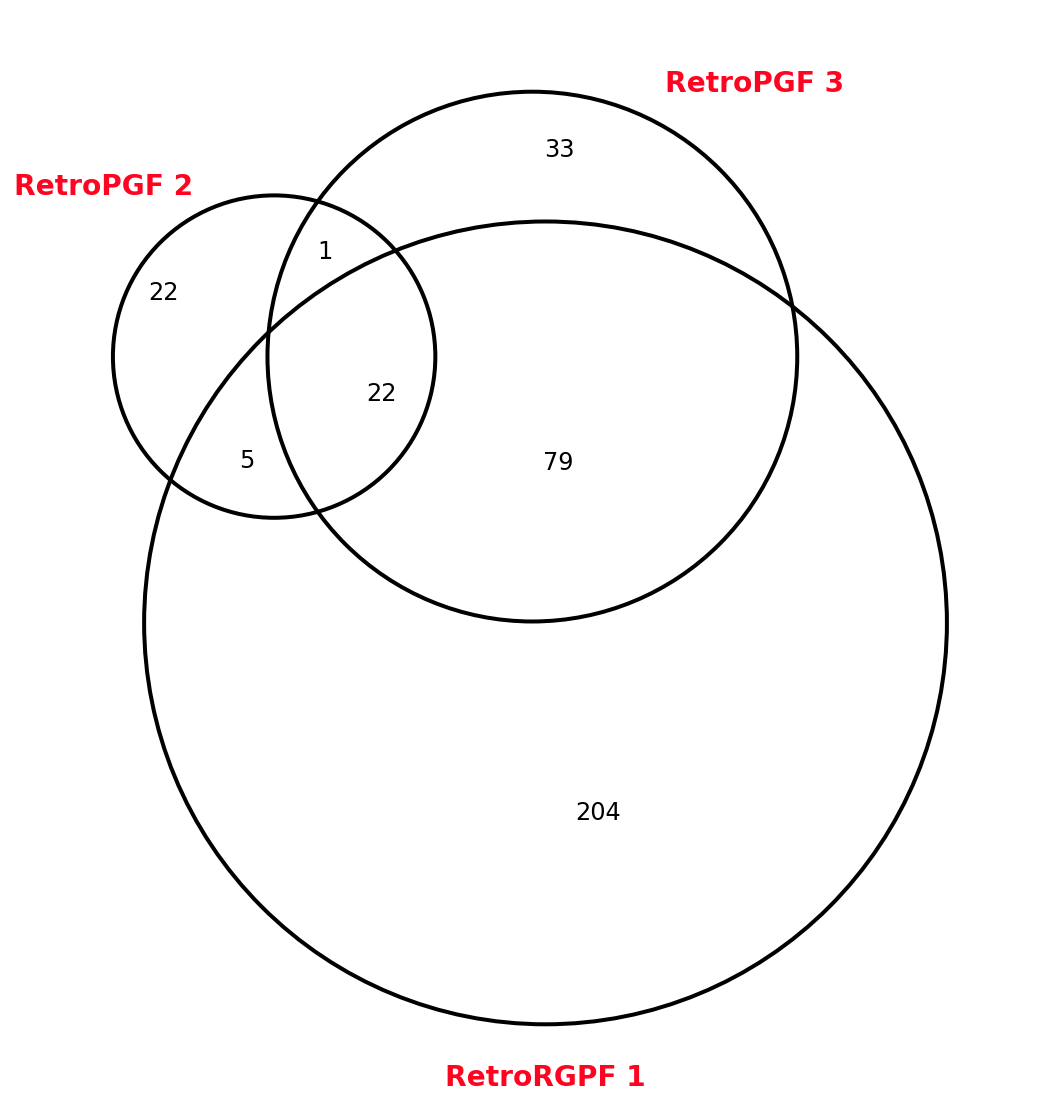

In [5]:
collection_slugs = ["op-rpgf1", "op-rpgf2", "op-rpgf3"]
all_slugs = set([p for c,ps in cpp.items() if c in collection_slugs for p in ps])
total_projects = len(all_slugs)
print("Total projects:", total_projects)

venn3_diagram(
    [set(ps) for c,ps in cpp.items() if c in collection_slugs], 
    ["RetroPGF 2", "RetroPGF 3", "RetroRGPF 1"],
    labelcolor=OP_RED,
    fontsize=12
)

# Developer Activity

In [6]:
def annualize_ticks(dataframe, ax):
    months = dataframe['month'].nunique()
    ax.set_xlim([0,months-1])
    ax.set_xticks([x for x in range(0,months,12)])
    xticklabels = [x[:-3] for x in sorted(df_devs['month'].unique())[::12]]
    ax.set_xticklabels(xticklabels)

In [7]:
slugs_param = "','".join(slugs)

devs_query = execute_query(f"""
    WITH Devs AS (
        SELECT 
            p."slug" AS "slug",
            e."fromId" AS "fromId",
            TO_CHAR(DATE_TRUNC('MONTH', e."time"), 'YYYY-MM') AS "month",
            CASE WHEN COUNT(DISTINCT e."time") >= 10 THEN 1 ELSE 0 END AS "active_developer"
                FROM event e             
        JOIN project_artifacts_artifact paa ON e."toId" = paa."artifactId"            
        JOIN project p ON paa."projectId" = p.id         
        WHERE
            e."typeId" = 4 -- COMMIT CODE EVENTS ONLY
            AND p.slug IN ('{slugs_param}')
        GROUP BY
            p."slug",
            e."fromId",
            TO_CHAR(DATE_TRUNC('MONTH', e."time"), 'YYYY-MM')
    )
    SELECT 
        slug,
        month,
        SUM("active_developer")
    FROM Devs
    WHERE month >= '{START_DATE[:-3]}' AND month < '{END_DATE[:-3]}'
    GROUP BY slug, month
    ORDER BY slug DESC, month;
""", col_names=True)

df_devs = pd.DataFrame(devs_query[1:], columns=devs_query[0])
df_devs.head()

slug    month  sum
0  zora  2019-01    4
1  zora  2019-02    4
2  zora  2019-03    3
3  zora  2019-04    2
4  zora  2019-05    4

Text(51.3, 10, 'RetroPGF 2')

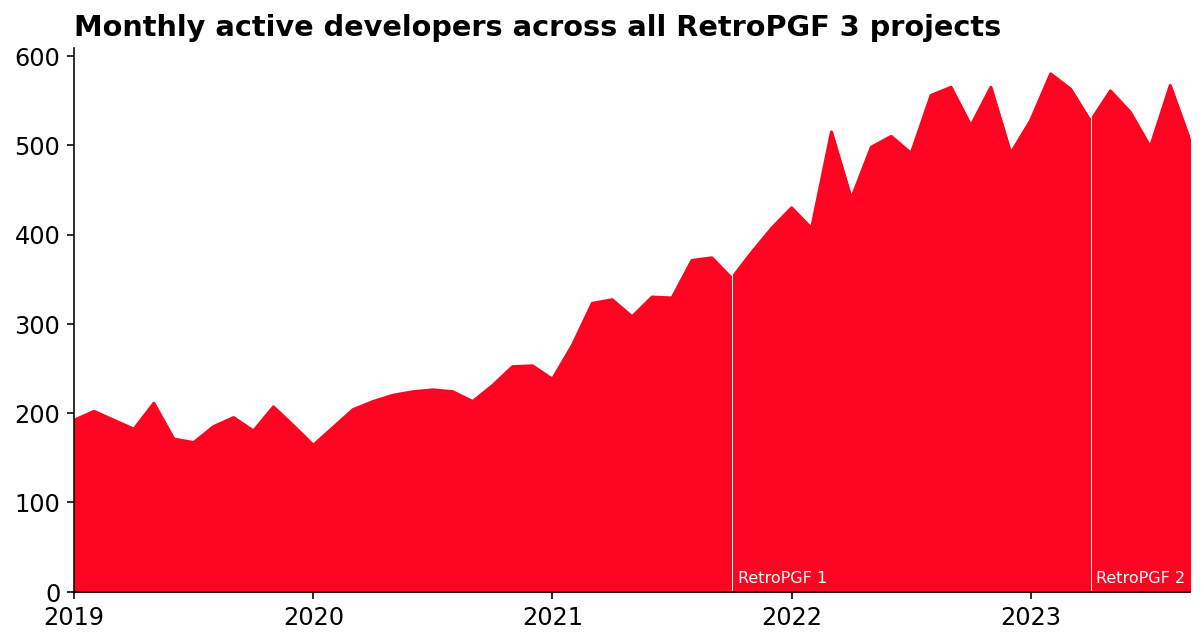

In [8]:
fig, ax = plt.subplots()
df_devs.groupby('month')['sum'].sum().plot(kind='area', ax=ax, color=OP_RED)
annualize_ticks(df_devs, ax)
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_title('Monthly active developers across all RetroPGF 3 projects', fontweight="bold", loc='left')

ax.vlines(x=33, ymin=0, ymax=600, colors='white', lw=.5)
ax.text(x=33.3, y=10, s='RetroPGF 1', color='white', fontsize=8)
ax.vlines(x=51, ymin=0, ymax=600, colors='white', lw=.5)
ax.text(x=51.3, y=10, s='RetroPGF 2', color='white', fontsize=8)

Text(42, 350, 'RetroPGF 3 only')

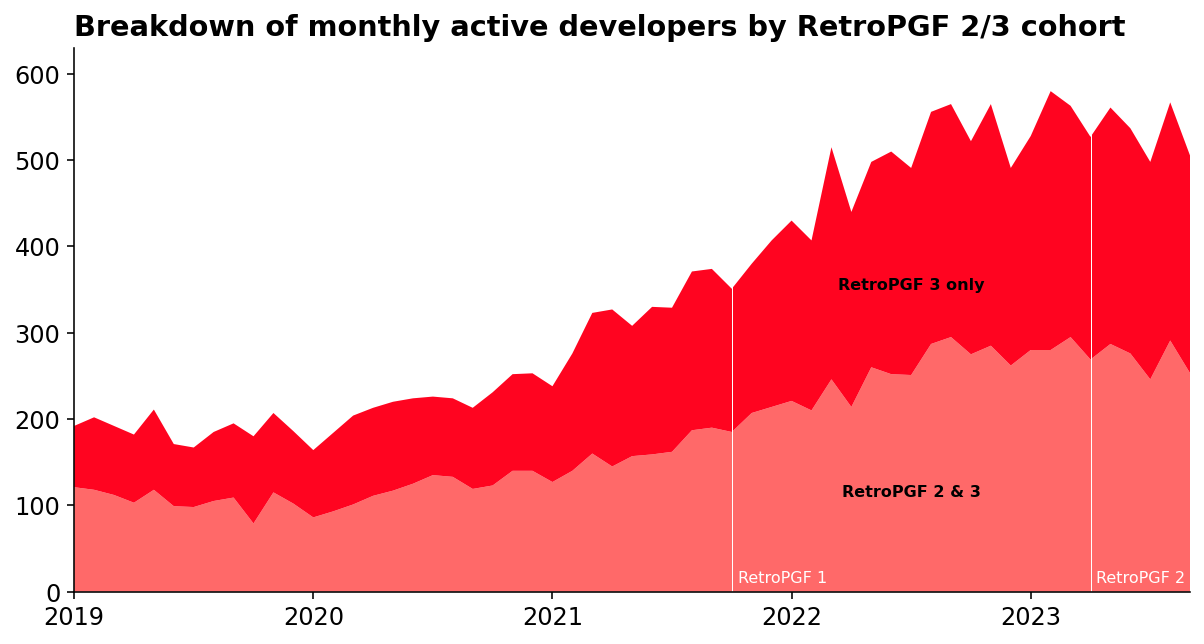

In [9]:
df_devs['in_rpgf2'] = df_devs['slug'].isin(cpp['op-rpgf2'])
pvt_devs = df_devs.pivot_table(
    index='in_rpgf2', 
    columns='month', 
    values='sum', 
    aggfunc='sum', 
    fill_value=0
)

fig, ax = plt.subplots()
ax.stackplot(
    pvt_devs.columns, 
    pvt_devs.loc[True], 
    pvt_devs.loc[False],
    colors=[OP_MED_RED, OP_RED]
)
annualize_ticks(df_devs, ax)
ax.set_title('Breakdown of monthly active developers by RetroPGF 2/3 cohort', fontweight="bold", loc='left')

ax.vlines(x=33, ymin=0, ymax=600, colors='white', lw=.5)
ax.text(x=33.3, y=10, s='RetroPGF 1', color='white', fontsize=8)
ax.vlines(x=51, ymin=0, ymax=600, colors='white', lw=.5)
ax.text(x=51.3, y=10, s='RetroPGF 2', color='white', fontsize=8)

ax.text(s='RetroPGF 2 & 3', x=42, y=110, ha='center', fontweight='bold', fontsize=8)
ax.text(s='RetroPGF 3 only', x=42, y=350, ha='center', fontweight='bold', fontsize=8)

In [10]:
all_slugs_param = "','".join([s for s in all_slugs if s not in individuals])

all_devs_query = execute_query(f"""
    WITH Devs AS (
        SELECT 
            p."slug" AS "slug",
            e."fromId" AS "fromId",
            TO_CHAR(DATE_TRUNC('MONTH', e."time"), 'YYYY-MM') AS "month",
            CASE WHEN COUNT(DISTINCT e."time") >= 10 THEN 1 ELSE 0 END AS "active_developer"
                FROM event e             
        JOIN project_artifacts_artifact paa ON e."toId" = paa."artifactId"            
        JOIN project p ON paa."projectId" = p.id         
        WHERE
            e."typeId" = 4 -- COMMIT CODE EVENTS ONLY
            AND p.slug IN ('{all_slugs_param}')
        GROUP BY
            p."slug",
            e."fromId",
            TO_CHAR(DATE_TRUNC('MONTH', e."time"), 'YYYY-MM')
    )
    SELECT 
        slug,
        month,
        SUM("active_developer")
    FROM Devs
    WHERE month >= '{START_DATE[:-3]}' AND month < '{END_DATE[:-3]}'
    GROUP BY slug, month;
""", col_names=True)

df_all_devs = pd.DataFrame(all_devs_query[1:], columns=all_devs_query[0])

def assign_tag(p):
    in_rpgf3 = p in cpp['op-rpgf3']
    in_rpgf2 = p in cpp['op-rpgf2']
    if in_rpgf3:
        if in_rpgf2:
            return "RPGF2 & RPGF3"
        else:
            return "RPGF3 only"
    return "Previous RPGFs"

df_all_devs['tag'] = df_all_devs['slug'].apply(assign_tag)
df_all_devs.head()

slug    month  sum            tag
0  0x-splits  2022-01    1  RPGF2 & RPGF3
1  0x-splits  2022-02    2  RPGF2 & RPGF3
2  0x-splits  2022-03    2  RPGF2 & RPGF3
3  0x-splits  2022-04    1  RPGF2 & RPGF3
4  0x-splits  2022-05    0  RPGF2 & RPGF3

Text(42, 460, 'RetroPGF 3 only')

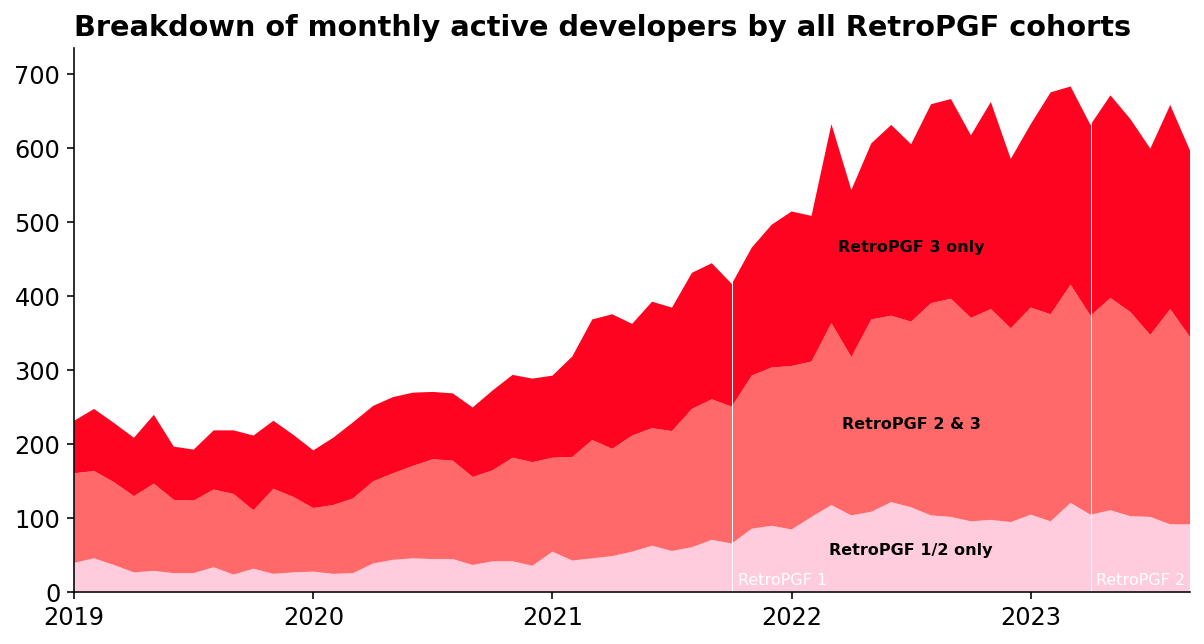

In [11]:
pvt_all_devs = df_all_devs.pivot_table(
    index='tag', 
    columns='month', 
    values='sum', 
    aggfunc='sum', 
    fill_value=0
)

fig, ax = plt.subplots()
ax.stackplot(
    pvt_all_devs.columns, 
    pvt_all_devs.loc["Previous RPGFs"], 
    pvt_all_devs.loc["RPGF2 & RPGF3"],
    pvt_all_devs.loc["RPGF3 only"],
    colors=[OP_LIGHT_RED, OP_MED_RED, OP_RED]
)
annualize_ticks(df_devs, ax)
ax.set_title('Breakdown of monthly active developers by all RetroPGF cohorts', fontweight="bold", loc='left')

ax.vlines(x=33, ymin=0, ymax=700, colors='white', lw=.5)
ax.text(x=33.3, y=10, s='RetroPGF 1', color='white', fontsize=8)
ax.vlines(x=51, ymin=0, ymax=700, colors='white', lw=.5)
ax.text(x=51.3, y=10, s='RetroPGF 2', color='white', fontsize=8)

ax.text(s='RetroPGF 1/2 only', x=42, y=50, ha='center', fontweight='bold', fontsize=8)
ax.text(s='RetroPGF 2 & 3', x=42, y=220, ha='center', fontweight='bold', fontsize=8)
ax.text(s='RetroPGF 3 only', x=42, y=460, ha='center', fontweight='bold', fontsize=8)

In [12]:
df_all_devs[df_all_devs['tag'] == 'Previous RPGFs']['slug'].nunique()

54

In [13]:
df_all_devs[df_all_devs['tag'] == 'Previous RPGFs'].groupby('slug')['sum'].mean().sort_values().tail(3)

slug
walletconnect     8.070175
safe-global       9.228070
code-423n4       15.047619
Name: sum, dtype: float64

Text(0.0, 1.0, 'Project activity 6 months before vs 6 months after RetroPGF 2')

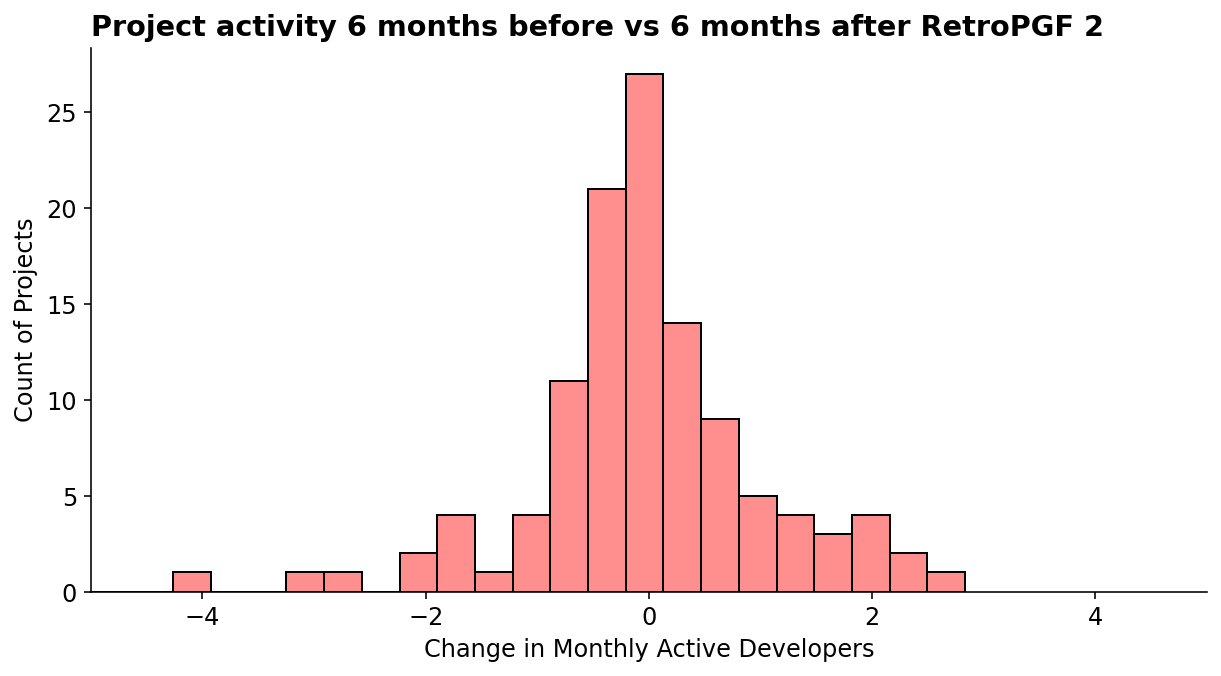

In [14]:
pvt_months = df_all_devs[df_all_devs['slug'].isin(cpp['op-rpgf2'])].pivot_table(
    index='slug', 
    columns='month', 
    values='sum', 
    aggfunc='mean', 
    fill_value=0
).iloc[:,-12:]
before = pvt_months.iloc[:,:6].mean(axis=1).rename("before")
after = pvt_months.iloc[:,6:].mean(axis=1).rename("after")

ba_df = pd.concat([before, after], axis=1)
ba_df = ba_df[ba_df.sum(axis=1)>0]
ba_df['delta'] = after - before

fig, ax = plt.subplots()
sns.histplot(ba_df['delta'], ax=ax, color=OP_MED_RED)
ax.set_xlim(-5,5)
ax.set_xlabel("Change in Monthly Active Developers")
ax.set_ylabel("Count of Projects")
ax.set_title("Project activity 6 months before vs 6 months after RetroPGF 2", fontweight="bold", loc='left')

In [15]:
df_all_devs['project'] = df_all_devs['slug'].map(slugs_to_names)

contribution_heatmap(
    df_all_devs,
    index_col='project',
    column_col='month',
    value_col='sum',
    sort_label_method='mean',
    dpi=300,
    cmap='Reds',
    figsize=(20,80)
)

(<Figure size 6000x24000 with 1 Axes>, <AxesSubplot:>)

# Onchain trends

In [16]:
slugs_param = "','".join(slugs)

results = execute_query(f"""
    SELECT 
        p.slug AS slug, 
        a.type AS artifact_type, 
        COUNT(DISTINCT a.id) AS count_artifacts
    FROM project p
    JOIN project_artifacts_artifact paa ON p."id" = paa."projectId"
    JOIN artifact a ON paa."artifactId" = a."id"
    WHERE p.slug IN ('{slugs_param}') AND a.namespace <> 'ETHEREUM'
    GROUP BY p.slug, a.type;
""", col_names=True)

df_artifacts = pd.DataFrame(results[1:], columns=results[0])
df_artifacts.head()

slug    artifact_type  count_artifacts
0  0x-splits      EOA_ADDRESS                1
1  0x-splits     SAFE_ADDRESS                1
2  0x-splits  FACTORY_ADDRESS                4
3  0x-splits   GIT_REPOSITORY               15
4  0x-splits      NPM_PACKAGE                2

In [17]:
onchain = df_artifacts[df_artifacts['artifact_type'].isin(['FACTORY_ADDRESS', 'CONTRACT_ADDRESS'])]['slug'].unique()
len(onchain)

86

In [18]:
onchain_slugs_param = "','".join(onchain)

users_query = execute_query(f"""
    WITH Users AS (
        SELECT 
            p."slug" AS "slug",
            TO_CHAR(DATE_TRUNC('MONTH', e."time"), 'YYYY-MM') AS "month",
            COUNT(DISTINCT e."fromId") AS "user_nums"
        FROM event e
        JOIN project_artifacts_artifact paa ON e."toId" = paa."artifactId"            
        JOIN project p ON paa."projectId" = p.id         
        WHERE
            e."typeId" = 25 -- TXN EVENTS ONLY
            AND p.slug IN ('{onchain_slugs_param}')
        GROUP BY
            p."slug",
            TO_CHAR(DATE_TRUNC('MONTH', e."time"), 'YYYY-MM')
    )
    SELECT 
        slug,
        month,
        SUM("user_nums")
    FROM Users
    WHERE month < '2023-11'
    GROUP BY slug, month;
""", col_names=True)

df_users = pd.DataFrame(users_query[1:], columns=users_query[0])
df_users['sum'] = df_users['sum'].apply(int)
df_users['project'] = df_users['slug'].map(slugs_to_names)
df_users.head()

slug    month  sum project
0  0x-splits  2022-10   19  Splits
1  0x-splits  2022-11   25  Splits
2  0x-splits  2022-12    7  Splits
3  0x-splits  2023-01    1  Splits
4  0x-splits  2023-02    3  Splits

(<Figure size 3000x7500 with 1 Axes>, <AxesSubplot:>)

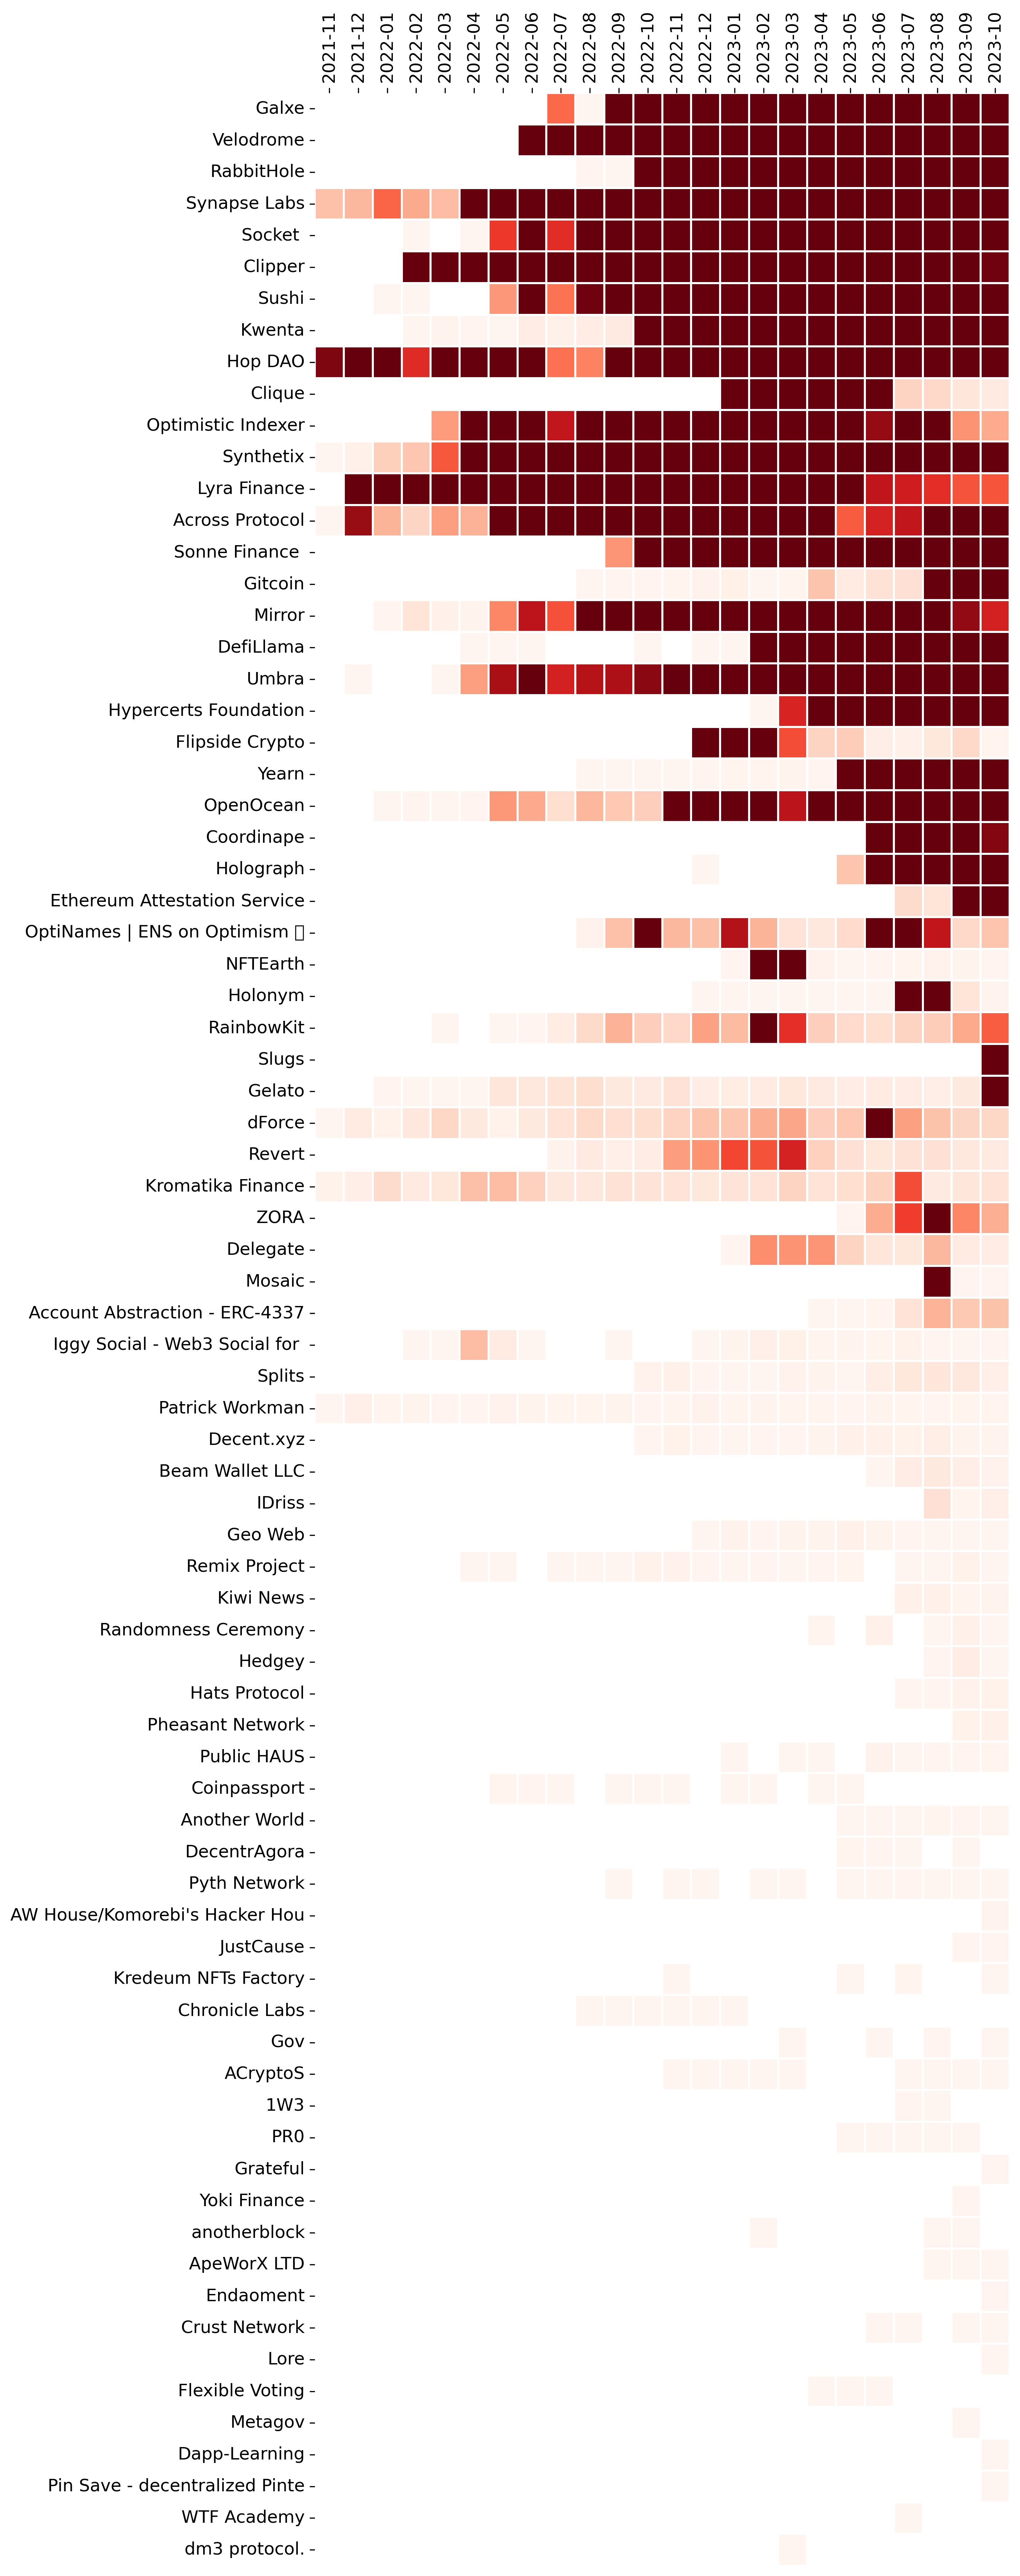

In [19]:
contribution_heatmap(
    df_users,
    index_col='project',
    column_col='month',
    value_col='sum',
    apply_groupby=False,
    sort_label_method='mean',
    vmax=1000,
    dpi=300,
    cmap='Reds',
    figsize=(10,25)
)

In [20]:
all_users_query = execute_query(f"""
    SELECT 
        p."slug" AS "slug",
        e."fromId" AS "user",
        TO_CHAR(DATE_TRUNC('MONTH', e."time"), 'YYYY-MM') AS "month",
        SUM(e."amount") as "txns"
    FROM event e
    JOIN project_artifacts_artifact paa ON e."toId" = paa."artifactId"            
    JOIN project p ON paa."projectId" = p.id         
    WHERE
        e."typeId" = 25 -- TXN EVENTS ONLY
        AND p.slug IN ('{onchain_slugs_param}')
    GROUP BY
        p."slug",
        e."fromId",
        TO_CHAR(DATE_TRUNC('MONTH', e."time"), 'YYYY-MM')
""", col_names=True)
df_all_users = pd.DataFrame(all_users_query[1:], columns=all_users_query[0])

In [21]:
# one app users
users_per_app = df_all_users.groupby('slug')['user'].nunique()

apps_per_user = df_all_users.groupby('user')['slug'].nunique()
multi_app_users = apps_per_user[apps_per_user>=3].index
maus_by_app = df_all_users[df_all_users['user'].isin(multi_app_users)].groupby('slug')['user'].nunique()

txns_per_user = df_all_users.groupby('user')['txns'].sum()
most_active_users = txns_per_user[txns_per_user>=30].index
recent_users = df_all_users[df_all_users['month'] >= '2023-08']['user'].index
hvaus = set(most_active_users).intersection(set(recent_users))
hvaus_by_app = df_all_users[df_all_users['user'].isin(hvaus)].groupby('slug')['user'].nunique()

In [22]:
print(len(apps_per_user))
print(len(multi_app_users))
print(len(hvaus))

1433427
433804
40221


In [23]:
pct = lambda x: round((x / users_per_app).fillna(0) * 100, 0)

project_user_summary = pd.concat([
    users_per_app.rename("# Users"),
    pct(maus_by_app).rename("% Multi-App Users"),    
    pct(hvaus_by_app).rename("% High Value Active Users")    
], axis=1).fillna(0).reset_index()

project_user_summary = project_user_summary[project_user_summary['# Users']>=420]
project_user_summary = project_user_summary[project_user_summary['slug'] != 'polynomial-protocol']

project_user_summary['Project'] = project_user_summary['slug'].map(slugs_to_names)
project_user_summary.set_index('Project', drop=True, inplace=True)
project_user_summary.drop(columns=['slug'], inplace=True)
project_user_summary.sort_values(by='# Users', inplace=True, ascending=False)
#project_user_summary['# Users'] = project_user_summary['# Users'].apply(lambda s: f"{s:,.0f}")

Text(0, 0.5, 'High value active users (%)')

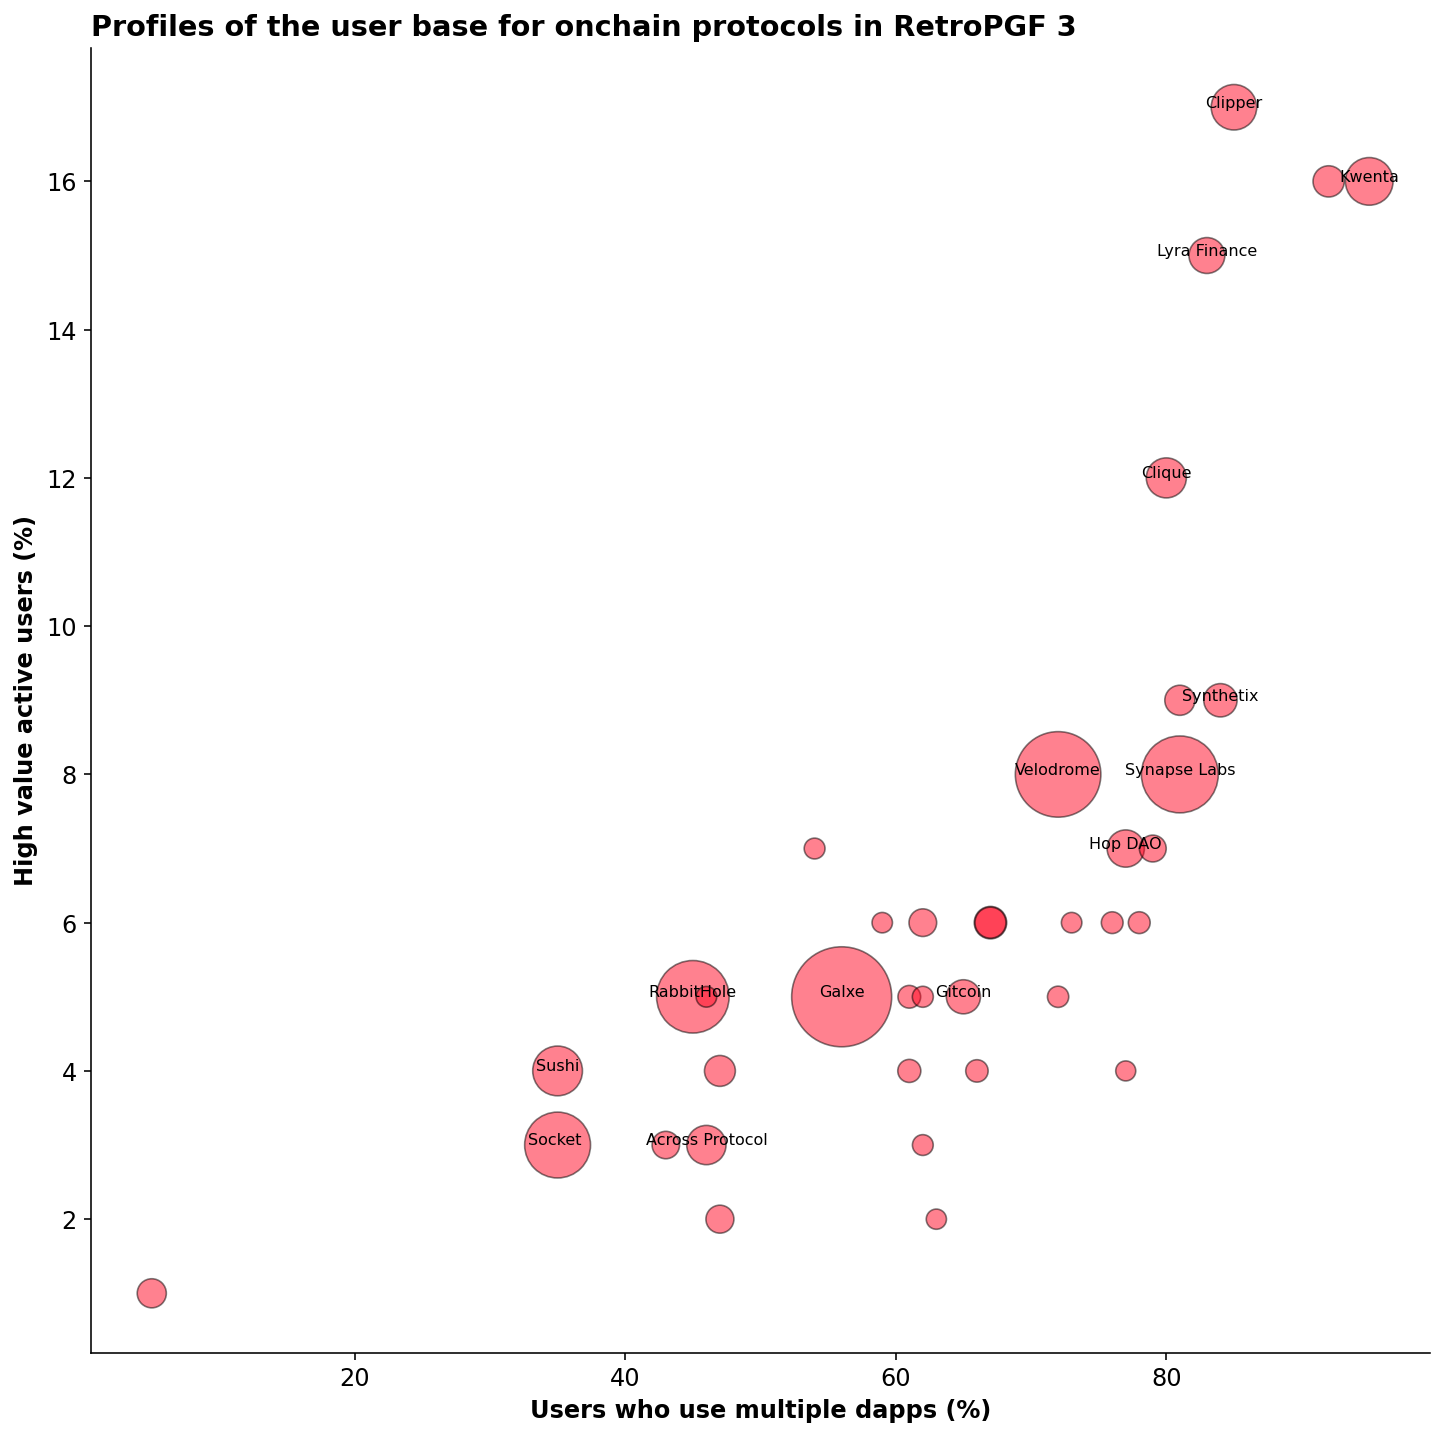

In [24]:
fig, ax = plt.subplots(figsize=(12,12))

sns.scatterplot(
    project_user_summary,
    x='% Multi-App Users',
    y='% High Value Active Users',
    size='# Users',
    color=OP_RED,
    alpha=.5,
    edgecolor='black',
    sizes=(100,2500),
    legend=False
)

for project, row in project_user_summary.iterrows():
    if row['# Users'] < 50000:
        continue
    ax.text(x=row['% Multi-App Users'], y=row['% High Value Active Users'], s=project, fontsize=8, ha='center')
    
ax.set_title('Profiles of the user base for onchain protocols in RetroPGF 3', fontweight="bold", loc='left')
ax.set_xlabel("Users who use multiple dapps (%)", fontweight='bold')
ax.set_ylabel("High value active users (%)", fontweight='bold')

Text(0.0, 1.0, 'The first dapp that "high value active users" interacted with on OP')

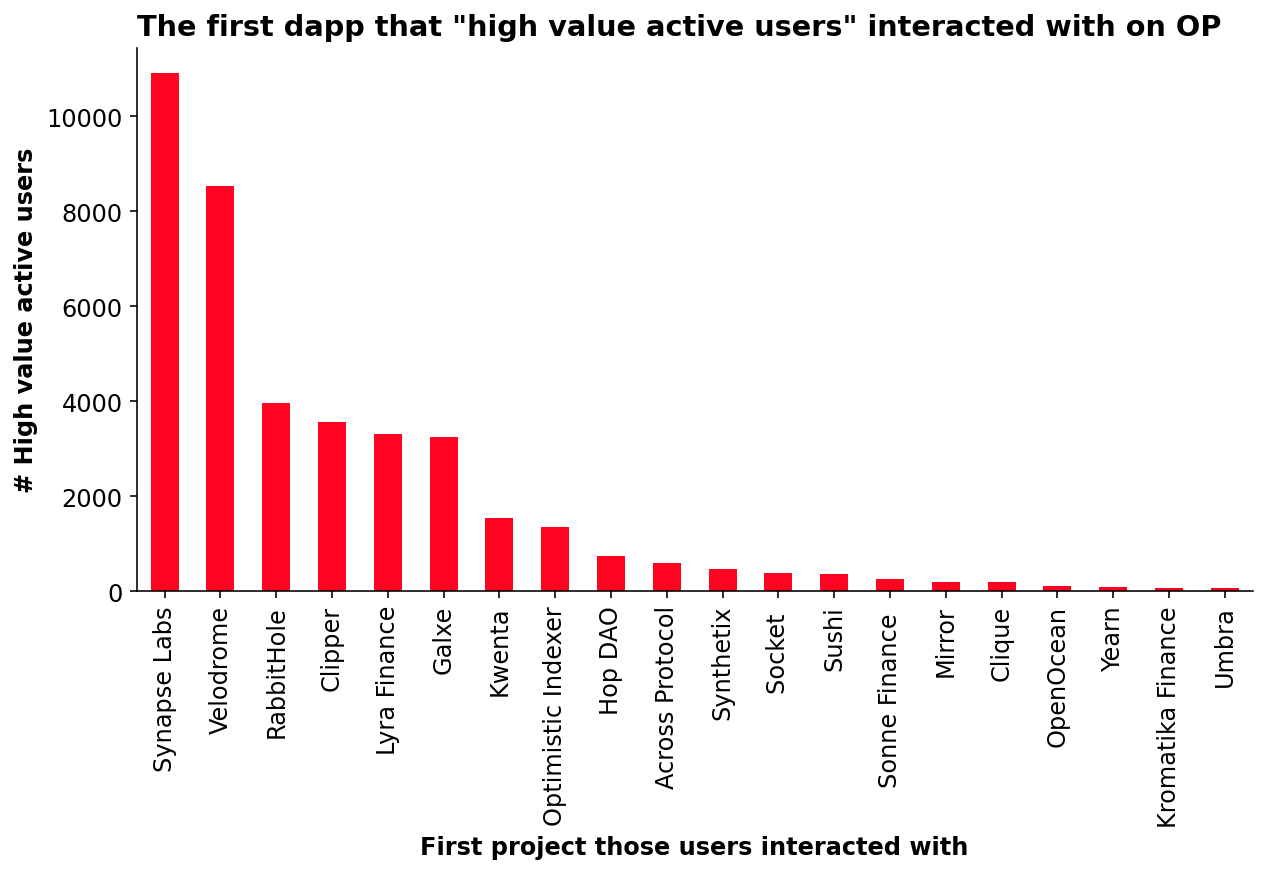

In [25]:
earliest_projects = df_all_users[df_all_users['user'].isin(hvaus)].sort_values(by='month').groupby('user').first().reset_index()
earliest_projects['name'] = earliest_projects['slug'].map(slugs_to_names)
ep_series = earliest_projects['name'].value_counts()
ep_series = ep_series[ep_series>50]

fig, ax = plt.subplots()
ep_series.plot(kind='bar', color=OP_RED, ax=ax)
ax.set_xlabel("First project those users interacted with", fontweight='bold')
ax.set_ylabel("# High value active users", fontweight='bold')
ax.set_title('The first dapp that "high value active users" interacted with on OP', fontweight="bold", loc='left')

# Direct and indirect impact

In [26]:
import plotly.express as px

In [27]:
fees_query = execute_query(f"""
    SELECT 
        p."slug" AS "slug",
        SUM(e."amount") as "fees"
    FROM event e
    JOIN project_artifacts_artifact paa ON e."toId" = paa."artifactId"            
    JOIN project p ON paa."projectId" = p.id         
    WHERE e."typeId" = 26 -- L2 FEES
    GROUP BY p."slug"
""", col_names=True)
df_fees = pd.DataFrame(fees_query[1:], columns=fees_query[0])

In [28]:
project_names = execute_query("select slug, name from project", col_names=False)
project_names = {x[0]:x[1] for x in project_names}

In [29]:
df_fees['project'] = df_fees['slug'].map(project_names)
df_fees['group'] = df_fees['slug'].apply(lambda x: 'RetroPGF' if x in onchain else "Other protocols")
df_fees['fees'] = df_fees['fees'] / 1e18
df_fees

slug       fees       project            group
0       0x-splits   0.003321      0xSplits         RetroPGF
1          1-inch   9.696114         1Inch  Other protocols
2             1w3   0.000006           1W3         RetroPGF
3    2-pi-network   0.002983   2Pi Network  Other protocols
4            aave   0.588268          Aave  Other protocols
..            ...        ...           ...              ...
216   yokifinance   0.000025  Yoki Finance         RetroPGF
217        zerion   0.503716        Zerion  Other protocols
218        zeroex  31.191068        zeroex  Other protocols
219      zonicapp   0.008422      ZonicApp  Other protocols
220          zora   0.109742          Zora         RetroPGF

[221 rows x 4 columns]

In [30]:
print(len(df_fees[df_fees['group']=='Other protocols']))
df_fees.groupby('group')['fees'].sum()

143


group
Other protocols    893.659942
RetroPGF           148.545610
Name: fees, dtype: float64

In [31]:
px.treemap(data_frame=df_fees, path=['group', 'project'], values='fees', title='Sequencer fee contribution by protocol')

In [32]:
dependencies = execute_query(f"""
    WITH DependentCollections AS (
        SELECT 
            c.id,
            c."artifactOwnerId",
            a."name",
            p."slug"
        FROM collection c
        JOIN project_artifacts_artifact paa ON c."artifactOwnerId" = paa."artifactId"
        JOIN project p ON paa."projectId" = p.id
        JOIN artifact a ON paa."artifactId" = a.id
        WHERE c."typeId" = 3
    )
    SELECT     
        dc."slug" AS "project",
        dc."name" AS "package",
        p."slug" AS "dependent"
    FROM project p
    JOIN collection_projects_project cpp ON p.id = cpp."projectId"
    JOIN DependentCollections dc ON cpp."collectionId" = dc.id
        WHERE dc."slug" <> p."slug"
""")

deps = set()
for (project, package, dependent) in dependencies[1:]:
    if '@wagmi' in package:
        package = '@wagmi/*'
    if '@safe' in package:
        package = '@safe/*'
    deps.add((project,package,dependent))

In [33]:
def make_sankey_graph(
    df, 
    cat_cols, 
    value_col,
    title,
    width=1000, 
    height=800, 
    size=12):

    # build the title info
    total = df[value_col].sum()
    max_nodes = max(df[cat_cols].nunique())
    line_width = min(.5, (height / max_nodes / 50))

    # make the Sankey
    labelList = []
    colorNumList = []
    for catCol in cat_cols:
        labelListTemp = list(set(df[catCol].values))
        colorNumList.append(len(labelListTemp))
        labelList = labelList + labelListTemp

    # remove duplicates from labelList
    labelList = list(dict.fromkeys(labelList))

    # define colors based on number of categories
    colorPalette = [OP_RED, OP_MED_RED, OP_LIGHT_RED]
    colorList = []
    for idx, colorNum in enumerate(colorNumList):
        colorList = colorList + [colorPalette[idx]]*colorNum

    # transform df into a source-target pair
    for i in range(len(cat_cols)-1):
        if i==0:
            sourceTargetDf = df[[cat_cols[i], cat_cols[i+1], value_col]]
            sourceTargetDf.columns = ['source','target','value']
        else:
            tempDf = df[[cat_cols[i],cat_cols[i+1],value_col]]
            tempDf.columns = ['source','target','value']
            sourceTargetDf = pd.concat([sourceTargetDf,tempDf])
        sourceTargetDf = sourceTargetDf.groupby(['source','target']
            ).agg({'value':'sum'}).reset_index()

    # add index for source-target pair
    sourceTargetDf['sourceID'] = sourceTargetDf['source'].apply(
        lambda x: labelList.index(x))
    sourceTargetDf['targetID'] = sourceTargetDf['target'].apply(
        lambda x: labelList.index(x))

    linkLabels = []
    for c in cat_cols:
        linkLabels += [c] * df[c].nunique()

    # creating the sankey diagram
    pad = 15
    node_thickness = 10
    data = dict(
        type='sankey',
        orientation='h',
        domain=dict(x=[0,1], y=[0,1]),
        arrangement='freeform', #'snap',
        node=dict(
          thickness=node_thickness,
          line=dict(color=OP_RED, width=line_width),
          label=labelList,
          color=colorList,
          customdata=linkLabels,
          hovertemplate="<br>".join([
                "<b>%{value:,.1f}</b>",
                "%{customdata}: %{label}",
                "<extra></extra>"
            ])
        ),
        link=dict(
          source=sourceTargetDf['sourceID'],
          target=sourceTargetDf['targetID'],
          value=sourceTargetDf['value'],
          hovertemplate="<br>".join([
                "<b>%{value:,.1f}</b>",
                "%{source.customdata}: %{source.label}",
                "%{target.customdata}: %{target.label}",
                "<extra></extra>"
            ])
        )
      )

    xpad = ((node_thickness+pad)/2)/width
    xpos = np.linspace(xpad, 1-xpad, len(cat_cols))

    layout = dict(
        title=dict(text=title, x=0, xref='paper', xanchor = "left"),
        font=dict(color=OP_RED, size=size), #family="Arial"
        autosize=True,
        height=height,
        annotations=[
            dict(
                text=f"<br><b>{cat}</b>",
                x=xpos[i], xref='paper', xanchor='center',                 
                y=-0.02, yref='paper', yanchor='top',                 
                font=dict(color=OP_RED, size=size+2),
                align='center', showarrow=False
            )
            for i, cat in enumerate(cat_cols)
        ]
    )
    fig = dict(data=[data], layout=layout)
    return fig

In [35]:
df_sankey = pd.DataFrame(deps, columns=dependencies[0])
cols = ['Project', 'Package', 'Dependent']
df_sankey.columns = cols
df_sankey = df_sankey.join(df_fees.set_index('slug')['fees'], on='Dependent', how='left').dropna()
df_sankey['Project'] = df_sankey['Project'].map(project_names)

total_fees = df_sankey[['Dependent', 'fees']].drop_duplicates()['fees'].sum()
title = f"<b>Downstream impact (npm data only)</b><br>Total fees = {total_fees:,.0f} ETH"
sankey_data = make_sankey_graph(df_sankey, cols, value_col='fees', title=title)

In [36]:
go.Figure(sankey_data)